## Look for a _plugin_ function

With the following code, you can search for a function and obtain information about its parameters

In [1]:
# Using Path in contemporary Python provides easy&safe helper functions
from pathlib import Path
sasfit_path = Path(r"C:\Users\tom\Downloads\SASfit-0.94.12-windows64")
sasfit_src_path = Path(r"Y:\shared\sasfit-code\src") # 'r' for raw string, avoids interpreting backslashes \

In [2]:
#
# This code gets all information about all the functions available as dll files
#

import os

# we get a list of the .dll files in the plugin folder
plugin_list = [
    fn.stem[10:]
    for fn in (sasfit_path / "plugins").iterdir()
    if fn.name.startswith("libsasfit_") and fn.suffix == ".dll"
]
#plugin_list

In [3]:
from pprint import pprint

# we extract information about the functions stored in each of the header files
functions = {}
debug = False
for plugin in plugin_list: # please use variables names telling something about their purpose
    filename = sasfit_src_path / "plugins" / plugin / "include" / f"sasfit_{plugin}.h"
    if debug:
        print(filename)
    with open(filename) as fh: # always use 'with' scope, handles file closing on exceptions for you
        try:
            for x in fh.read().split("/* ################ start ")[1:]:
                ftype = x[:2]
                name = (x[3:].split(" ################ */"))[0]
                description = (x.split("* \\brief")[1]).split(
                    "<more detailed documentation, see 'doxygen' docs>"
                )[0].splitlines()
                # filter out leading ' *' C-style comments from 2nd line on
                description = "".join([description[0]]
                                        +[line.strip().removeprefix("*")
                                          for line in description[2:]]).strip()
                #print(f"{ftype=}, {name=}, {description=}")

                parameters_section = x.split("\\par Required parameters:")[1].split("</table>")[0]
                #print(1,f"{parameters_section=}")
                # extract parameter name and description
                parameters = [par_field.split("</td>")[0].removeprefix(r"\b").strip()
                              for par_field in parameters_section.split("<td>")][1:]
                # group parameters to (name, description) tuples
                parameters = list(zip(*(iter(parameters),)*2))
                functions[name] = {
                    "name": name,
                    "type": ftype,
                    "description": description,
                    "parameters": parameters,
                    "group": plugin, # this should be 'plugin' instead of 'group', right?
                                     # perhaps, confused with SF plugin groups defined in .def files
                }
                if debug:
                    pprint(functions[name])
                    print()
        except:
            raise
            print("\n")  # Error retrieving parameters for "+i+"\n\n")


In [7]:
search = input(" * * * * * * *\nSearch for a particular function:")
print("\n * * * * * * *\n")

for func in functions: # please use variables names telling something about their purpose
    if search in func:
        print(func + "\n")
        print(functions[func]["description"])
        print("\nParameters:\n")
        for p in functions[func]["parameters"]:
            print(":\t".join(p))
        print("\n * * * * * * *\n")

 * * * * * * *
Search for a particular function: saupe



 * * * * * * *

maiersaupe__deg_

\<some brief description of MaierSaupe (deg) function\>

Parameters:

I0:	flat background
A:	anisotropic amplitude
kappa:	width
delta:	reference direction  relative to horizontal direction in degree

 * * * * * * *

maiersaupe__rad_

\<some brief description of MaierSaupe (rad) function\>

Parameters:

I0:	flat background
A:	anisotropic amplitude
kappa:	width
delta:	reference direction relative to horizontal direction in radian

 * * * * * * *

azimuthal_sheared_cylinders_maier_saupe

\<some brief description of Sheared Cylinders (Maier-Saupe) azimuthal function\>

Parameters:

R:	core radius
t:	shell thickness
L:	cylinder length
eta_core:	scattering length density of core
eta_shell:	scattering length density of shell
eta_solv:	scattering length density of solvent
Q:	scattering vector
sigma:	width parameter of lognormal size distribution of radii
kappa:	orientation distribution parameter
dummy:	not used
dummy:	not used

 * * * * * * *

azimuthal_shear

## Obtain the values for a function by means of the _.dll_ file

You can copy the name and group of the function you looked for above and obtain useful values for your code.

### Required imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
from ctypes import *
import sys
import os

In [2]:
# Using Path in contemporary Python provides easy&safe helper functions
from pathlib import Path
sasfit_path = Path(r"C:\Users\tom\Downloads\SASfit-0.94.12-windows64")
sasfit_src_path = Path(r"Y:\shared\sasfit-code\src") # 'r' for raw string, avoids interpreting backslashes \

### Need to define the SASfit parameter structure first
Needed to get error messages and such ...

In [3]:
# has to match the value in
# https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_constants.h#L45
MAXPAR = 50
STRLEN = 256 # defined below MAXPAR in the same file

# defining an equivalent of the C sasfit_param struct
# https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_function.h#L146
# according to https://docs.python.org/3/library/ctypes.html#structures-and-unions
class SASFIT_PARAM(ctypes.Structure):
    _fields_ = [("p", ctypes.c_double * MAXPAR),
                # sasfit_kernel_type, numbered sequentially, in:
                # https://github.com/SASfit/SASfit/blob/master/src/sasfit_common/include/sasfit_function.h#L118
                ("kernelSelector", ctypes.c_int),
                ("kernelSubSelector", ctypes.c_int),
                ("errStr", ctypes.c_char * STRLEN),
                ("errLen", ctypes.c_int),
                ("errStatus", ctypes.c_int),
                ("xarr", ctypes.c_void_p),
                ("yarr", ctypes.c_void_p),
                ("moreparam", ctypes.c_void_p),
                ("more_p", ctypes.c_double * MAXPAR),
                # function pointer, set to void* for now, not sure where this is used
                ("function", ctypes.c_void_p)
               ]

### Rebuilding SASfit data structures at play
Required for plugin management functions, such as setting the *stub* pointer (points to a table of internal SASfit functions, also some frequently used numerical algos). *SASfit does this for each plugin it loads.*

In [4]:
## Python implementation of *examples/example_sasfit_ff_fuzzysphere.c*
SASFIT_FUNC_ONE_T = CFUNCTYPE(c_double, c_double, POINTER(SASFIT_PARAM))
SASFIT_FUNC_VOL_T = CFUNCTYPE(c_double, c_double, POINTER(SASFIT_PARAM), c_int)
class SASFIT_PLUGIN_FUNC_T(ctypes.Structure):
    _fields_ = [("len", ctypes.c_int),
                ("name", ctypes.c_char_p),
                ("func", POINTER(SASFIT_FUNC_ONE_T)),
                ("func_f", POINTER(SASFIT_FUNC_ONE_T)),
                ("func_v", POINTER(SASFIT_FUNC_VOL_T)),]
class SASFIT_PLUGIN_INFO_T(ctypes.Structure):
    _fields_ = [("num", ctypes.c_int),
                ("functions", POINTER(SASFIT_PLUGIN_FUNC_T))]
SASFIT_PLUGIN_SEARCH_T = CFUNCTYPE(c_int, c_double, POINTER(SASFIT_PLUGIN_INFO_T))
class SASFIT_COMMON_STUBS_T(ctypes.Structure):
    _fields_ = [("func", ctypes.c_void_p*155),
                ]
# define the Python variant of *sasfit_plugin_api_t* structure
GET_VER_FUNC_T = CFUNCTYPE(c_int)
DO_INIT_FUNC_T = CFUNCTYPE(c_int, POINTER(POINTER(SASFIT_PLUGIN_INFO_T)),
                                   POINTER(SASFIT_COMMON_STUBS_T),
                                   POINTER(SASFIT_PLUGIN_SEARCH_T))
class SASFIT_PLUGIN_API_T(ctypes.Structure):
    _fields_ = [("get_ver_func", GET_VER_FUNC_T),
                ("do_init_func", ctypes.c_void_p),
                ("names", ctypes.c_char_p * 2)]

## Load main SASfit DLL and init the Plugin

In [5]:
SASFIT_PLUGIN_API = SASFIT_PLUGIN_API_T()
os.chdir(sasfit_path) # needs to load dependent libs in main dir
SASFIT_DLL = cdll.LoadLibrary(str(sasfit_path / "lib" / "libsasfit.dll"))
SASFIT_DLL.sasfit_plugin_api_reset(byref(SASFIT_PLUGIN_API))

SASFIT_PEAK_DLL = cdll.LoadLibrary(str(sasfit_path / "plugins" / "libsasfit_peak.dll"))
SASFIT_DLL.sasfit_plugin_api_set.restype = None
SASFIT_DLL.sasfit_plugin_api_set(byref(SASFIT_PLUGIN_API), 0, SASFIT_PEAK_DLL.get_ver)
SASFIT_DLL.sasfit_plugin_api_set(byref(SASFIT_PLUGIN_API), 1, SASFIT_PEAK_DLL.do_init)
SASFIT_PEAK_DLL.get_ver(), SASFIT_PLUGIN_API.get_ver_func(), GET_VER_FUNC_T(SASFIT_PEAK_DLL.get_ver)()

(101, 101, 101)

In [6]:
SASFIT_DLL.sasfit_common_stubs_ptr.restype = POINTER(SASFIT_COMMON_STUBS_T)
stubs = SASFIT_DLL.sasfit_common_stubs_ptr()
stubs.contents.func[51]

140710346528240

In [7]:
CFUNCTYPE(c_double, c_double)(stubs.contents.func[33])(1.1) # sasfit_si(1.1)

1.0286852186737148

In [8]:
pi = (POINTER(SASFIT_PLUGIN_INFO_T)*1)()
bool(pi)

True

In [9]:
SASFIT_PEAK_DLL.do_init.restype = ctypes.c_int
#SASFIT_PEAK_DLL.do_init.argtypes = (POINTER(POINTER(SASFIT_PLUGIN_INFO_T)),
#                                    POINTER(SASFIT_COMMON_STUBS_T),
#                                    POINTER(SASFIT_PLUGIN_SEARCH_T))
SASFIT_PEAK_DLL.do_init(byref(pi), SASFIT_DLL.sasfit_common_stubs_ptr(), SASFIT_DLL.sasfit_plugin_search)

1

In [10]:
pi[0].contents.num

74

In [35]:
param = SASFIT_PARAM((1, 4, 2.2, 0, 0, 0.2))
print(list(param.p))
print(param.errStatus, param.errLen, param.errStr)

[1.0, 4.0, 2.2, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0 0 b''


**TODO**: *sasfit_init_param()*?

### Note: Mind the stubs!

They do not appear as DLL deps but are accessed, such as sasfit_param_set_err() on error.
The stub pointer is set pointing to sasfit.dll structure during plugin loading, the latter has to be replicated with python (TBD)

Error?: 0 0 b''


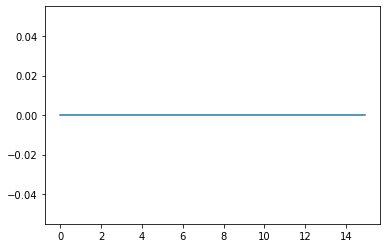

In [12]:
def read_dll(xvec, *args):
    #read_gaussian = cdll.LoadLibrary(str(sasfit_path / "plugins" / "libsasfit_peak.dll")).sasfit_peak_gaussian_amplitude
    read_gaussian = SASFIT_PEAK_DLL.sasfit_peak_gaussian_amplitude
#    read_gpolymer= cdll.LoadLibrary("C:\SASfit-0.94.12\plugins\libsasfit_polymer_chains.dll").sasfit_ff_gauspoly
#    read_HS=cdll.LoadLibrary("C:\SASfit-0.94.12\plugins\libsasfit_hard_spheres.dll").sasfit_sq_hard_sphere__4_3_
    
    read_gaussian.restype = c_double
#    read_gpolymer.restype = c_double
#    read_HS.restype = c_double
    #read_gaussian.argtypes = c_double, (ctypes.c_double * 6), #ctypes.c_int, ctypes.c_int, (ctypes.c_char * STRLEN)
    
    par = SASFIT_PARAM((args[:3]+(0, 0)+args[3:]))
    par.p[2] *= -1 # SASFIT_CHECK_COND1() raising an error here
    
    # list comprehensions are faster typically
    result = [read_gaussian(c_double(x), par) for x in xvec]
    print("Error?:", par.errStatus, par.errLen, par.errStr)
    return result

xvec = np.arange(0, 15, 0.1)
plt.ion()
plt.plot(xvec, read_dll(xvec, 1, 4, 2.2, 0.2))
plt.show()

In [27]:
import ctypes
from ctypes import *
import sys
import os

read_gaussian=cdll.LoadLibrary(str(sasfit_path / "plugins" / "libsasfit_peak.dll")).sasfit_peak_gaussian_amplitude

par=(ctypes.c_double * 6)(*[3, 5, 2.2, 0, 0, 0.4])

read_gaussian.restype = c_double

read_gaussian(c_double(4.2), POINTER(c_double)(par))


3.2080676736862443